In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/plants-home/WhatsApp Image 2024-04-21 at 12.41.48 PM (1).jpeg
/kaggle/input/plants-home/WhatsApp Image 2024-04-21 at 12.41.48 PM.jpeg
/kaggle/input/plants-home/WhatsApp Image 2024-04-21 at 12.41.49 PM.jpeg
/kaggle/input/vit-tree1/vit_tree.jpg
/kaggle/input/dry-plants-healthy-plants/dry plants/dry_15.jpg
/kaggle/input/dry-plants-healthy-plants/dry plants/dry_20.jpg
/kaggle/input/dry-plants-healthy-plants/dry plants/dry_26.jpg
/kaggle/input/dry-plants-healthy-plants/dry plants/dry_14.jpg
/kaggle/input/dry-plants-healthy-plants/dry plants/dry_19.jpg
/kaggle/input/dry-plants-healthy-plants/dry plants/dry_33.jpg
/kaggle/input/dry-plants-healthy-plants/dry plants/dry_8.jpg
/kaggle/input/dry-plants-healthy-plants/dry plants/dry_5.jpg
/kaggle/input/dry-plants-healthy-plants/dry plants/dry_10.jpg
/kaggle/input/dry-plants-healthy-plants/dry plants/dry_21.jpg
/kaggle/input/dry-plants-healthy-plants/dry plants/dry_7.jpg
/kaggle/input/dry-plants-healthy-plants/dry plants/dry_27.jpg
/k

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
import pandas as pd



2024-04-22 07:08:41.603085: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-22 07:08:41.603293: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-22 07:08:41.806545: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Constants
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 8

In [4]:
# Directory containing images of healthy and dry plants
Healthy_dir = "/kaggle/input/dry-plants-healthy-plants/Healthy plants"
dry_dir = "/kaggle/input/dry-plants-healthy-plants/dry plants"


In [5]:
# Get list of healthy and dry image files
Healthy_files = [os.path.join(Healthy_dir, filename) for filename in os.listdir(Healthy_dir)]
dry_files = [os.path.join(dry_dir, filename) for filename in os.listdir(dry_dir)]

In [6]:
# Create labels for cats (0) and dogs (1)
Healthy_labels = np.zeros(len(Healthy_files))
dry_labels = np.ones(len(dry_files))


In [7]:
# Concatenate file paths and labels
file_paths = Healthy_files + dry_files
labels = np.concatenate([Healthy_labels, dry_labels])

# Create DataFrame
df = pd.DataFrame({"Filepath": file_paths, "Label": labels})

# Shuffle DataFrame
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split DataFrame into training and validation sets
train_df = df.iloc[:int(0.8*len(df))]
val_df = df.iloc[int(0.8*len(df)):]


In [8]:
# Data preprocessing and augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)


In [9]:
# Create DataFrame with labels as strings
df = pd.DataFrame({"Filepath": file_paths, "Label": labels.astype(str)})

# Shuffle DataFrame
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split DataFrame into training and validation sets
train_df = df.iloc[:int(0.8*len(df))]
val_df = df.iloc[int(0.8*len(df)):]

# Data preprocessing and augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)


Found 56 validated image filenames belonging to 2 classes.
Found 14 validated image filenames belonging to 2 classes.


In [10]:
# Load pre-trained MobileNetV2 model
base_model = MobileNetV2(input_shape=(*IMAGE_SIZE, 3), include_top=False, weights='imagenet')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [11]:
# Freeze base layers
base_model.trainable = False

# Add custom classification head
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)


In [12]:
# Create model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator
)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 501ms/step - accuracy: 0.5532 - loss: 0.7231 - val_accuracy: 0.8571 - val_loss: 0.3891
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step - accuracy: 0.8932 - loss: 0.2523 - val_accuracy: 0.7857 - val_loss: 0.4477
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step - accuracy: 0.9189 - loss: 0.1473 - val_accuracy: 0.8571 - val_loss: 0.3087
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 225ms/step - accuracy: 1.0000 - loss: 0.1151 - val_accuracy: 0.8571 - val_loss: 0.2944
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step - accuracy: 1.0000 - loss: 0.0668 - val_accuracy: 0.8571 - val_loss: 0.2850
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 207ms/step - accuracy: 0.9955 - loss: 0.0313 - val_accuracy: 0.8571 - val_loss: 0.2731
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 224ms/step - accuracy: 0.9573 - loss: 0.1090 - val_accuracy: 0.8571 - val_loss: 0.2835
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 225ms/step - accuracy: 1.0000 - loss: 0.0251 - val_accuracy: 0.8571 - val_loss: 0.2890
Ep

In [13]:

# Evaluate model
test_loss, test_acc = model.evaluate(val_generator)
print("Test Accuracy:", test_acc)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.8631 - loss: 0.1519
Test Accuracy: 0.8571428656578064


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted label: Healthy


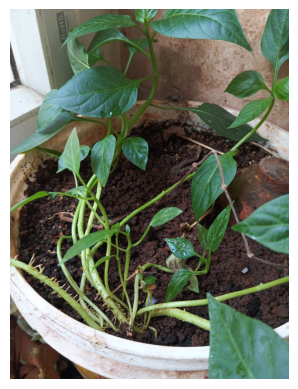

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image



# Preprocess the new images
def preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Rescale pixel values
    return img_array

# Example usage
img_path = "/kaggle/input/plants-home/WhatsApp Image 2024-04-21 at 12.41.48 PM.jpeg"
img_array = preprocess_image(img_path, target_size=(224, 224))

# Predict the label of the new image
prediction = model.predict(img_array)

# Decode the prediction
predicted_label = "Dry" if prediction > 0.5 else "Healthy"
print("Predicted label:", predicted_label)

# Display the image
img = image.load_img(img_path)
plt.imshow(img)
plt.axis('off')
plt.show()








1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Predicted label: Healthy


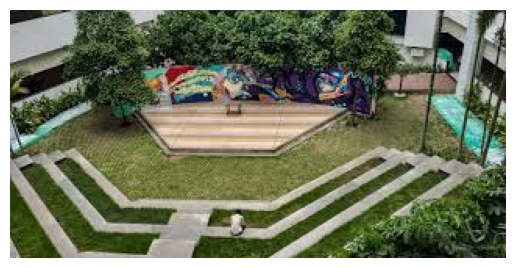

In [15]:
img_path2 = "/kaggle/input/vit-tree1/vit_tree.jpg"
img_array2 = preprocess_image(img_path2, target_size=(224, 224))

# Predict the label of the new image
prediction = model.predict(img_array2)

# Decode the prediction
predicted_label = "Dry" if prediction > 0.5 else "Healthy"
print("Predicted label:", predicted_label)
plt.show()
# Display the image
img2 = image.load_img(img_path2)
plt.imshow(img2)
plt.axis('off')
plt.show()

In [16]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision()])


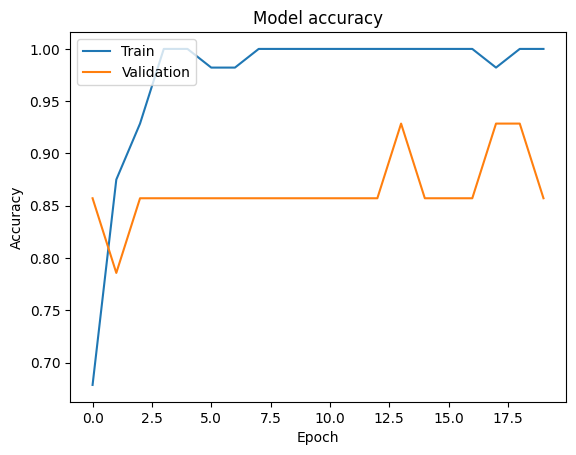

In [17]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()



2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step


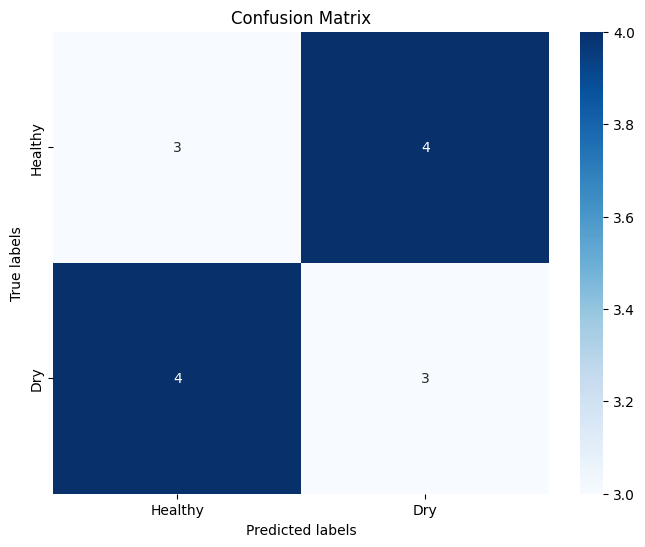

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions for the validation data
predictions = model.predict(val_generator)
y_true = val_generator.classes
y_pred = predictions > 0.5

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Dry'], yticklabels=['Healthy', 'Dry'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


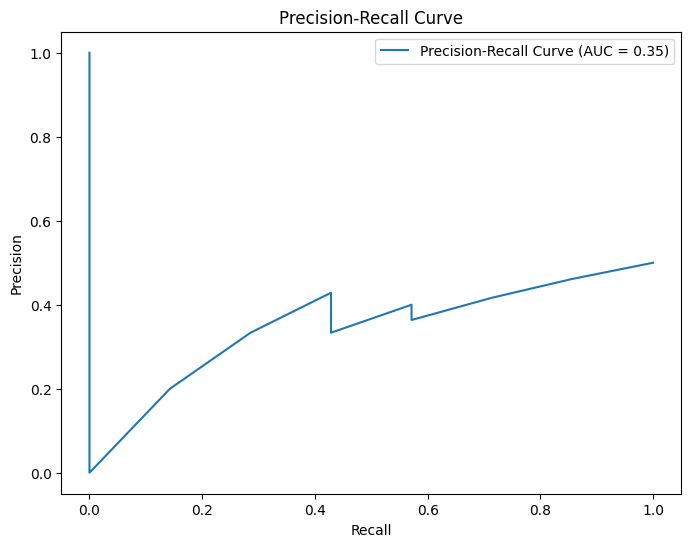

In [19]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

# Calculate precision and recall
precision, recall, _ = precision_recall_curve(y_true, predictions)

# Calculate area under the curve (AUC) for precision-recall curve
auc_score = auc(recall, precision)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall Curve (AUC = {auc_score:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()


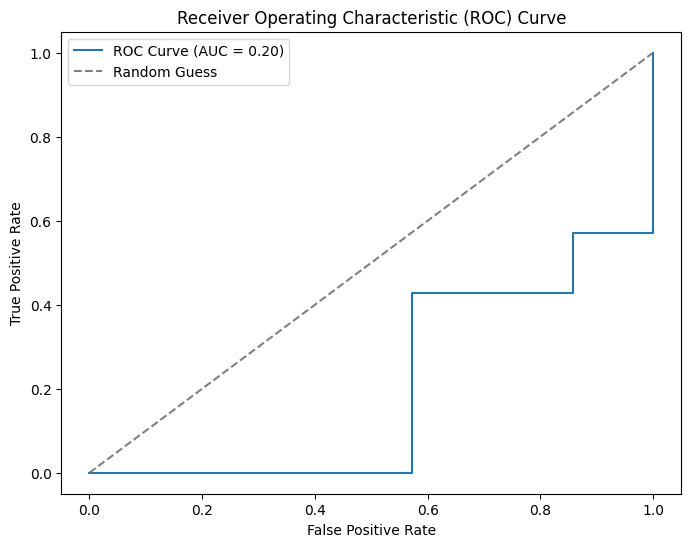

In [20]:
from sklearn.metrics import roc_curve

# Calculate false positive rate and true positive rate
fpr, tpr, _ = roc_curve(y_true, predictions)

# Calculate area under the curve (AUC) for ROC curve
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='best')
plt.show()


In [21]:
from sklearn.metrics import classification_report

# Get predictions for the validation data
predictions = model.predict(val_generator)
y_true = val_generator.classes
y_pred = predictions > 0.5

# Generate classification report
report = classification_report(y_true, y_pred, target_names=['Healthy', 'Dry'])
print(report)



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
              precision    recall  f1-score   support

     Healthy       0.29      0.29      0.29         7
         Dry       0.29      0.29      0.29         7

    accuracy                           0.29        14
   macro avg       0.29      0.29      0.29        14
weighted avg       0.29      0.29      0.29        14



In [22]:
from sklearn.metrics import precision_score

# Calculate precision for each class
precision_healthy = precision_score(y_true, y_pred, pos_label=0)
precision_dry = precision_score(y_true, y_pred, pos_label=1)

print("Precision for Healthy class:", precision_healthy)
print("Precision for Dry class:", precision_dry)

Precision for Healthy class: 0.2857142857142857
Precision for Dry class: 0.2857142857142857
